In [1]:
#import packages
import pandas as pd
import numpy as np
import sqlite3
from tqdm.auto import tqdm
from tqdm import tqdm_notebook
#use tqdm in pandas lambda loops
tqdm.pandas()
#parallel processing
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/jva/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# get station data

In [2]:
#get weather station dataframe
df_stations = pd.read_csv('weatherdata/stations.csv')

#convert wban and usaf columns to strings and create concatenated reference columns from two values
df_stations['usaf']  = df_stations['usaf'].astype('str')
df_stations['wban']  = df_stations['wban'].astype('str')
df_stations['ref_key'] = df_stations['usaf'] + df_stations['wban']

#narrow dataset
df_stations = df_stations[['ref_key', 'lat', 'lon']]

# get fire data

In [3]:
#create dataframe by querying Fires table from *.sqlite database
connection = sqlite3.connect('fire_database.sqlite')
firedf = pd.read_sql_query('''SELECT FIRE_YEAR,
                                     DISCOVERY_DOY,
                                     FIRE_SIZE,
                                     LATITUDE,
                                     LONGITUDE,
                                     STAT_CAUSE_DESCR,
                                     STATE
                              FROM Fires''', connection)

#formats day of year and year to standard yyyy-mm-dd date format
firedf['FORMATTED_DATE'] = pd.to_datetime(firedf['FIRE_YEAR'] * 1000 + firedf['DISCOVERY_DOY'], format='%Y%j')

# Define Functions for finding closest lat / lon

In [4]:
#use Haversine Distance fromula to find distance from fires to stations
from math import radians, cos, sin, asin, sqrt
def dist(lat1, long1, lat2, long2):
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

#to match nearest stations to fires
def find_nearest(lat, long):
    distances = weatherwith_stations.apply(
        lambda row: dist(lat, long, row['lat'], row['lon']), 
        axis=1)
    return (weatherwith_stations.loc[distances.idxmin(), 'ref_key'], distances.min())

# import csv for each year and loop through each year and match fire observation based on nearest station latitude and longitude 

In [5]:
#declare master output dataframe for each looped result to be appended
fires_output = pd.DataFrame()
#loop through each year
for year in tqdm_notebook(range(1992, 2016)):
    #get weather data csv
    weather_df = pd.read_csv('weatherdata/US_weather_{}.csv'.format(year))
    #create date column yyyy-mm-dd
    weather_df['formatted_date'] = pd.to_datetime(weather_df['year']*10000+weather_df['mo']*100+weather_df['da'],
                                                    format='%Y%m%d')
    #create refkey column
    weather_df['stn'] = weather_df['stn'].astype('str')
    weather_df['wban'] = weather_df['wban'].astype('str')
    weather_df['ref_key'] = weather_df['stn'] + weather_df['wban']
    #merge stations data to weather data
    weatherwith_stations = pd.merge(weather_df, 
                                    df_stations, 
                                    how='inner', 
                                    left_on='ref_key', 
                                    right_on = 'ref_key')
    #filter to weather stations that only have over 345 observations which is 75 percent of weather stations
    weatherwith_stations = weatherwith_stations.groupby(['ref_key','lat','lon'])['formatted_date'].count()
    weatherwith_stations = pd.DataFrame(weatherwith_stations)
    weatherwith_stations.reset_index(inplace=True)
    weatherwith_stations = weatherwith_stations[weatherwith_stations['formatted_date'] >= 345]
    #filter fire dataset
    firedf2 = firedf[firedf['FIRE_YEAR'] == year]
    #apply functions to find nearest stations:
    firedf2['ref_key'] = firedf2.parallel_apply(
        lambda row: find_nearest(row['LATITUDE'], row['LONGITUDE']), 
        axis=1)
    #convert resulting tuple to columns
    firedf2[['weather_obs_key', 'distance']] = pd.DataFrame(firedf2['ref_key'].tolist(), 
                                                                  index=firedf2.index)
    #append results
    fires_output = fires_output.append(firedf2)


<ipython-input-5-fa00e9f43bfa>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for year in tqdm_notebook(range(1992, 2016)):


/home/jva/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (22,24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<ipython-input-5-fa00e9f43bfa>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  firedf2['ref_key'] = firedf2.parallel_apply(
/home/jva/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


/home/jva/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


/home/jva/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


/home/jva/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
#describe distance distribution
fires_output['distance'].describe()

count    1.880465e+06
mean     3.685680e+01
std      2.350581e+01
min      0.000000e+00
25%      1.880022e+01
50%      3.269817e+01
75%      5.033188e+01
max      8.355979e+02
Name: distance, dtype: float64

In [12]:
fires_output.sample(50)

,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,STAT_CAUSE_DESCR,STATE,FORMATTED_DATE,ref_key,weather_obs_key,distance
293582,2000,64,73.20,35.050000,-107.542300,Debris Burning,NM,2000-03-04,"(72365023050, 84.32947700057599)",72365023050,84.329477
1756051,2014,107,2.00,38.287600,-92.865650,Debris Burning,MO,2014-04-17,"(72445953931, 34.64779736945564)",72445953931,34.647797
102728,1997,275,0.50,34.366667,-87.300000,Arson,AL,1997-10-02,"(72323513896, 50.15190075051172)",72323513896,50.151901
405895,2004,156,4.50,29.186110,-82.630000,Lightning,FL,2004-06-04,"(99464099999, 39.176722631066994)",99464099999,39.176723
1582404,2012,114,0.10,42.981100,-108.917800,Debris Burning,WY,2012-04-23,"(72576024021, 24.19125708998845)",72576024021,24.191257
1354491,1994,113,44.00,42.179420,-78.704621,Debris Burning,NY,1994-04-23,"(7252664751, 42.7894824374592)",7252664751,42.789482
668126,2007,213,0.20,47.745860,-117.429900,Children,WA,2007-08-01,"(72785694176, 10.734764593976466)",72785694176,10.734765
1275620,2009,123,2.00,45.181190,-91.558620,Debris Burning,WI,2009-05-03,"(72646754909, 31.31122197677561)",72646754909,31.311222
1010373,1994,64,1.00,36.071700,-80.461700,Debris Burning,NC,1994-03-05,"(72319393807, 22.621709063104838)",72319393807,22.621709
1814165,2015,52,0.50,31.841944,-103.117222,Equipment Use,TX,2015-02-21,"(72265623040, 10.56489018681169)",72265623040,10.564890


[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1160cadac0>]]


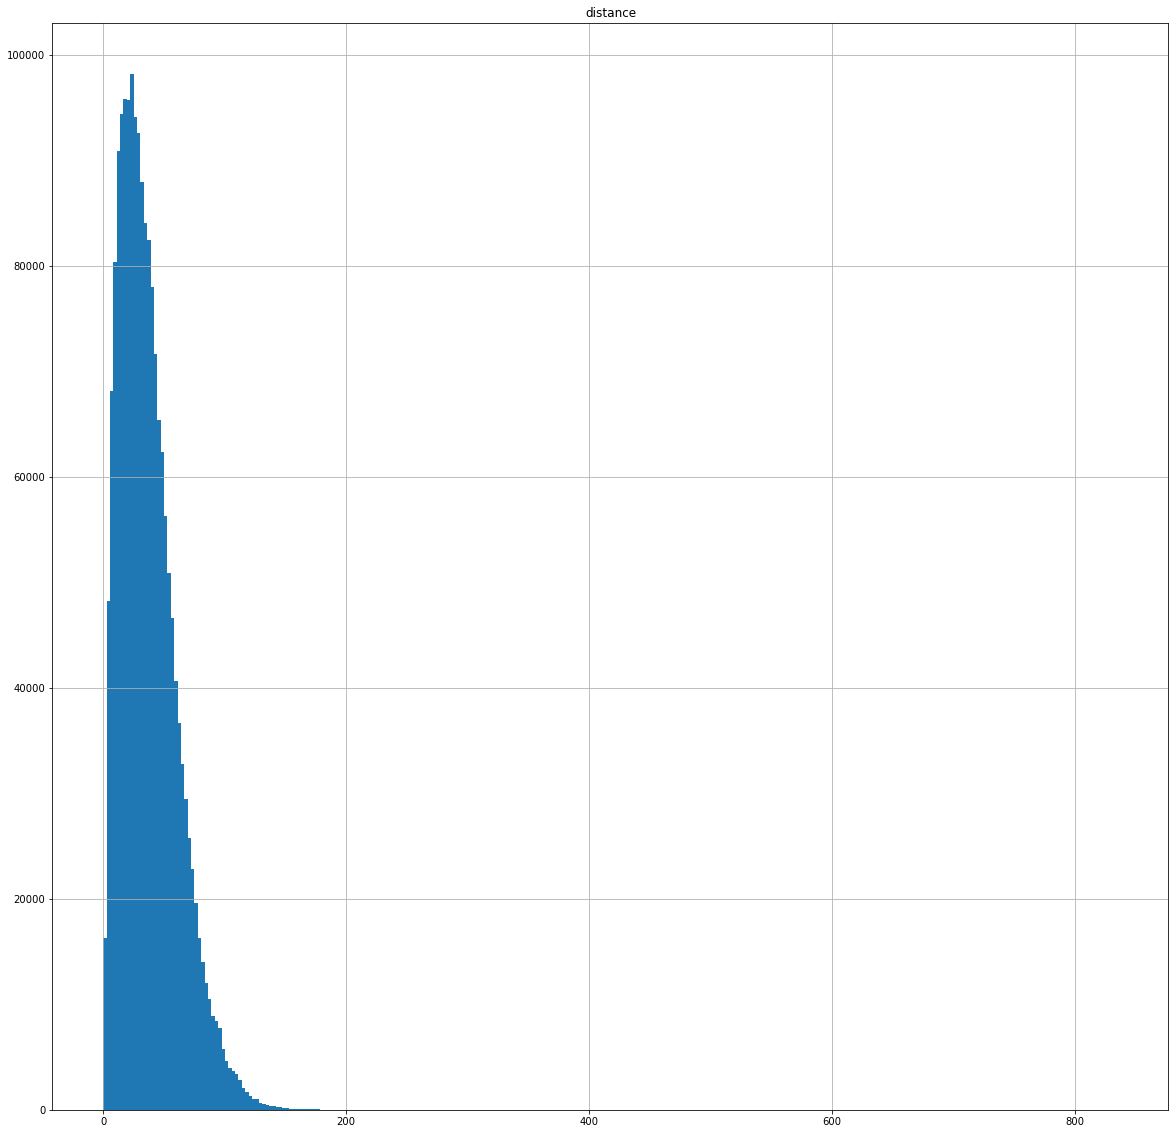

In [9]:
#visualize distribution of distance to stations
print(fires_output.hist(column = 'distance', bins=300,figsize=(20,20)))

In [8]:
#info about resulting dataframe
fires_output.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1880465 entries, 41875 to 1880464
Data columns (total 11 columns):
 #   Column            Dtype         
---  ------            -----         
 0   FIRE_YEAR         int64         
 1   DISCOVERY_DOY     int64         
 2   FIRE_SIZE         float64       
 3   LATITUDE          float64       
 4   LONGITUDE         float64       
 5   STAT_CAUSE_DESCR  object        
 6   STATE             object        
 7   FORMATTED_DATE    datetime64[ns]
 8   ref_key           object        
 9   weather_obs_key   object        
 10  distance          float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(4)
memory usage: 172.2+ MB


In [10]:
#outputdataset to csv
fires_output.to_csv('full_fire_output_allstations_345.csv', index=False)